In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import DashScopeEmbeddings

load_dotenv()

True

# Setup

In [3]:
llm = ChatOpenAI(model="qwen-plus")

In [4]:
embeddings = DashScopeEmbeddings(model="text-embedding-v3")

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Chains

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [7]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [9]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [10]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query when the answer is not known."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    print(f"Retrieved: {serialized}")
    print(f"retrieved_docs: {retrieved_docs}")
    return serialized, retrieved_docs

In [14]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]
    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
           or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages
    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

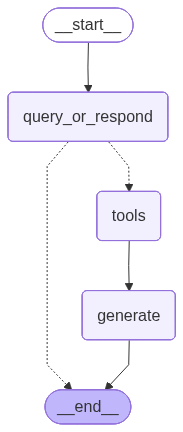

In [15]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges("query_or_respond",
                                    tools_condition,
                                    {END: END, "tools": "tools"})
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
input_message = "Hello"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [17]:
input_message = "What is Task Decomposition mentioned in the blog?"

events = graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition mentioned in the blog?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_6152374e62bd45d9b022bf)
 Call ID: call_6152374e62bd45d9b022bf
  Args:
    query: Task Decomposition blog
Retrieved: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates

In [15]:
for message in event['messages']:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition mentioned in the blog?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_7714404c518c41c2a202ed)
 Call ID: call_7714404c518c41c2a202ed
  Args:
    query: Task Decomposition mentioned in the blog
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into sma

## Stateful management of chat history

In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [22]:
input_message = "What is Task Decomposition mentioned in the blog?"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition mentioned in the blog?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_22891b380f244b4aa3b210)
 Call ID: call_22891b380f244b4aa3b210
  Args:
    query: Task Decomposition mentioned in the blog
Retrieved: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and sh

In [18]:
input_message = "Can you look up some common ways of doing it in the blog?"

for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    step["messages"][-1].pretty_print()

NameError: name 'config' is not defined

In [28]:
snape = graph.get_state(config)
for message in snape.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition mentioned in the blog?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_22891b380f244b4aa3b210)
 Call ID: call_22891b380f244b4aa3b210
  Args:
    query: Task Decomposition mentioned in the blog
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into sma

# Agents

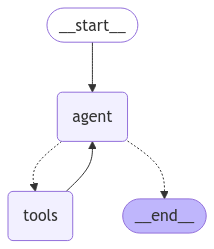

In [40]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [43]:
config = {"configurable": {"thread_id": "def2345"}}

input_message = (
    "What is the standard method for Task Decomposition in the bolg?\n\n"
    "Once you get the answer from bolg with tool, look up common extensions of that method."
)

for event in agent_executor.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition in the bolg?

Once you get the answer from bolg with tool, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_7832229a9c52424e8f5b8b)
 Call ID: call_7832229a9c52424e8f5b8b
  Args:
    query: standard method for Task Decomposition in the blog
Retrieved: Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by

In [44]:
snape = graph.get_state(config)
for message in snape.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition in the bolg?

Once you get the answer from bolg with tool, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_7832229a9c52424e8f5b8b)
 Call ID: call_7832229a9c52424e8f5b8b
  Args:
    query: standard method for Task Decomposition in the blog
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated 